In [ ]:
import pandas as pd
import numpy as np

# -------------------------
# Load datasets
# -------------------------
customers = pd.read_csv("olist_customers_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
geo = pd.read_csv("olist_geolocation_dataset.csv")

# -------------------------
# Prepare geolocation (average lat/long per zip_prefix)
# -------------------------
geo_grouped = geo.groupby("geolocation_zip_code_prefix").agg({
    "geolocation_lat": "mean",
    "geolocation_lng": "mean"
}).reset_index()

geo_grouped.rename(columns={
    "geolocation_zip_code_prefix": "zip_prefix",
    "geolocation_lat": "lat",
    "geolocation_lng": "lng"
}, inplace=True)

# -------------------------
# Merge customer coordinates
# -------------------------
customers = customers.rename(columns={"customer_zip_code_prefix": "zip_prefix"})
customers_geo = customers.merge(geo_grouped, on="zip_prefix", how="left")
customers_geo.rename(columns={"lat": "customer_lat", "lng": "customer_lng"}, inplace=True)

# -------------------------
# Merge seller coordinates
# -------------------------
sellers = sellers.rename(columns={"seller_zip_code_prefix": "zip_prefix"})
sellers_geo = sellers.merge(geo_grouped, on="zip_prefix", how="left")
sellers_geo.rename(columns={"lat": "seller_lat", "lng": "seller_lng"}, inplace=True)

# -------------------------
# Link orders → customers
# -------------------------
orders_cust = orders.merge(customers_geo, on="customer_id", how="left")

# Link order_items → sellers
order_items_sellers = order_items.merge(sellers_geo, on="seller_id", how="left")

# Combine to attach customer + seller coords per item
merged = order_items_sellers.merge(
    orders_cust[["order_id", "customer_lat", "customer_lng"]],
    on="order_id",
    how="left"
)

# -------------------------
# Haversine distance
# -------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

merged["distance_km"] = haversine(
    merged["customer_lat"],
    merged["customer_lng"],
    merged["seller_lat"],
    merged["seller_lng"]
)

# -------------------------
# Example outputs
# -------------------------
overall_avg_distance = merged["distance_km"].mean()
distance_per_seller = merged.groupby("seller_id")["distance_km"].mean()
distance_per_order = merged.groupby("order_id")["distance_km"].mean()

print("Overall avg distance (km):", overall_avg_distance)
print(distance_per_seller.head())
print(distance_per_order.head())


Overall avg distance (km): 596.9591827347291
seller_id
0015a82c2db000af6aaaf3ae2ecb0532    606.289835
001cca7ae9ae17fb1caed9dfb1094831    810.671619
001e6ad469a905060d959994f1b41e4f    394.314884
002100f778ceb8431b7a1020ff7ab48f    523.292032
003554e2dce176b5555353e4f3555ac8    935.999012
Name: distance_km, dtype: float64
order_id
00010242fe8c5a6d1ba2dd792cb16214    301.504681
00018f77f2f0320c557190d7a144bdd3    585.563937
000229ec398224ef6ca0657da4fc703e    312.343511
00024acbcdf0a6daa1e931b038114c75    293.168420
00042b26cf59d7ce69dfabb4e55b4fd9    646.163463
Name: distance_km, dtype: float64


# Historgram - Distance

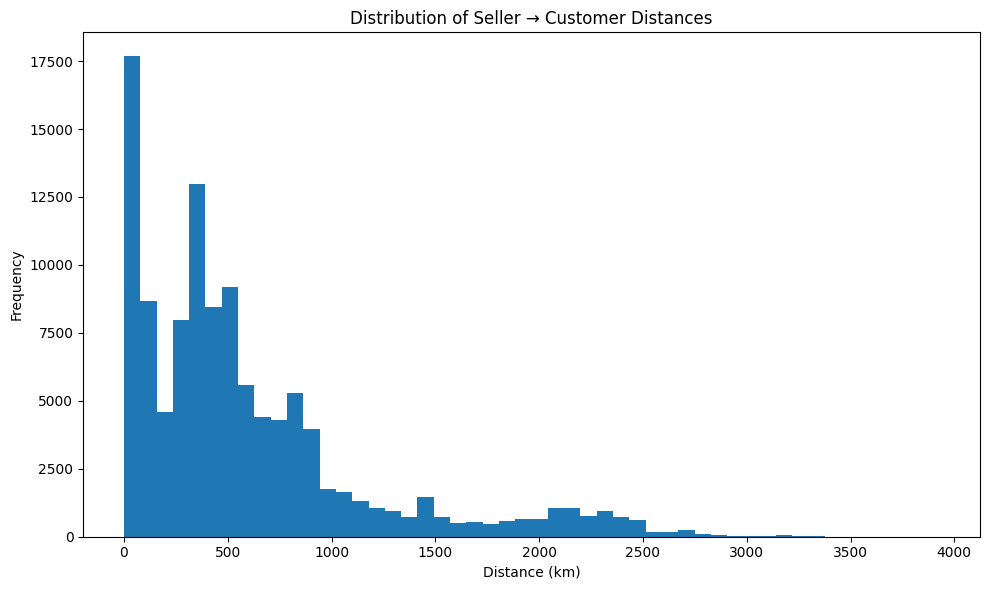

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------
# Load all Olist datasets
# ------------------------------------
customers = pd.read_csv("olist_customers_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
geo = pd.read_csv("olist_geolocation_dataset.csv")

# ------------------------------------
# Prepare geolocation averages by zip prefix
# ------------------------------------
geo_grouped = geo.groupby("geolocation_zip_code_prefix").agg({
    "geolocation_lat": "mean",
    "geolocation_lng": "mean"
}).reset_index()

geo_grouped.rename(columns={
    "geolocation_zip_code_prefix": "zip_prefix",
    "geolocation_lat": "lat",
    "geolocation_lng": "lng"
}, inplace=True)

# ------------------------------------
# Merge customer geolocation
# ------------------------------------
customers2 = customers.rename(columns={"customer_zip_code_prefix": "zip_prefix"})
customers_geo = customers2.merge(geo_grouped, on="zip_prefix", how="left")
customers_geo.rename(columns={"lat": "customer_lat", "lng": "customer_lng"}, inplace=True)

# ------------------------------------
# Merge seller geolocation
# ------------------------------------
sellers2 = sellers.rename(columns={"seller_zip_code_prefix": "zip_prefix"})
sellers_geo = sellers2.merge(geo_grouped, on="zip_prefix", how="left")
sellers_geo.rename(columns={"lat": "seller_lat", "lng": "seller_lng"}, inplace=True)

# ------------------------------------
# Link orders → customers
# ------------------------------------
orders_cust = orders.merge(customers_geo, on="customer_id", how="left")

# Link order_items → sellers
order_items_sellers = order_items.merge(sellers_geo, on="seller_id", how="left")

# Combine to attach customer coords per order item
merged = order_items_sellers.merge(
    orders_cust[["order_id", "customer_lat", "customer_lng"]],
    on="order_id",
    how="left"
)

# ------------------------------------
# Haversine distance calc
# ------------------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

merged["distance_km"] = haversine(
    merged["customer_lat"],
    merged["customer_lng"],
    merged["seller_lat"],
    merged["seller_lng"]
)

# ------------------------------------
# Histogram of distances
# ------------------------------------

# distances = merged["distance_km"].dropna()
distances = merged.loc[(merged["distance_km"].notna()) & (merged["distance_km"] <= 4000), "distance_km"]

plt.figure(figsize=(10,6))
plt.hist(distances, bins=50)
plt.xlabel("Distance (km)")
plt.ylabel("Frequency")
plt.title("Distribution of Seller → Customer Distances")
plt.tight_layout()
plt.show()


With late % added

/tmp/ipython-input-1965044927.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["bin"] = pd.cut(df["distance_km"], bins=bins, include_lowest=True)
/tmp/ipython-input-1965044927.py:112: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  late_pct = df.groupby("bin")["late"].mean() * 100


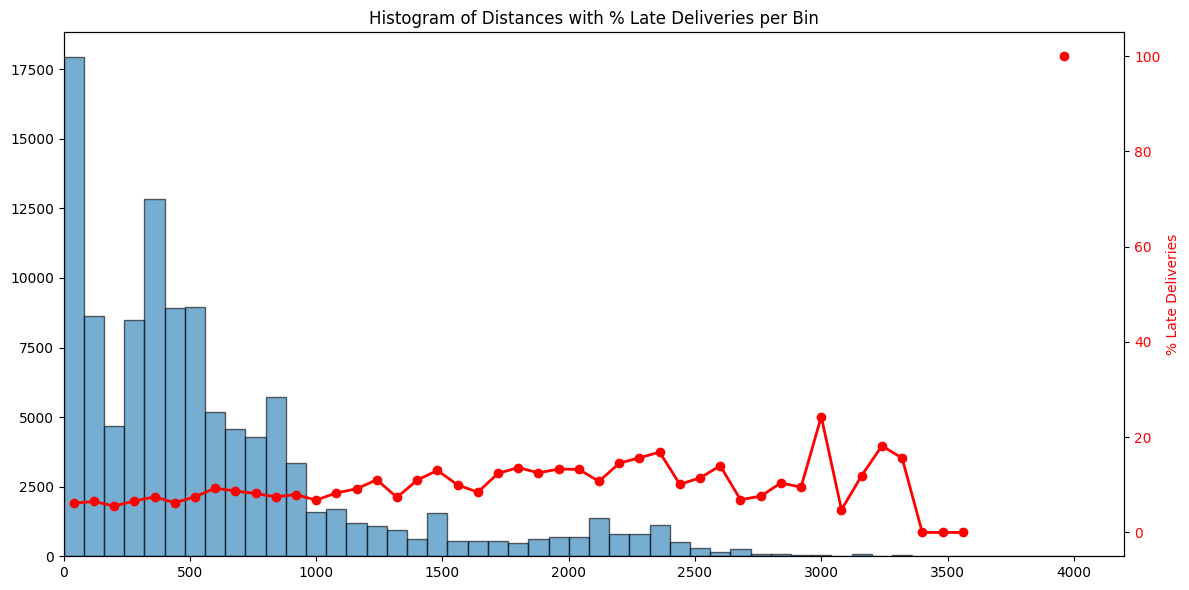

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------
# Load all Olist datasets
# ------------------------------------
customers = pd.read_csv("olist_customers_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
geo = pd.read_csv("olist_geolocation_dataset.csv")

# ------------------------------------
# Prepare geolocation averages by zip prefix
# ------------------------------------
geo_grouped = geo.groupby("geolocation_zip_code_prefix").agg({
    "geolocation_lat": "mean",
    "geolocation_lng": "mean"
}).reset_index()

geo_grouped.rename(columns={
    "geolocation_zip_code_prefix": "zip_prefix",
    "geolocation_lat": "lat",
    "geolocation_lng": "lng"
}, inplace=True)

# ------------------------------------
# Merge customer geolocation
# ------------------------------------
customers2 = customers.rename(columns={"customer_zip_code_prefix": "zip_prefix"})
customers_geo = customers2.merge(geo_grouped, on="zip_prefix", how="left")
customers_geo.rename(columns={"lat": "customer_lat", "lng": "customer_lng"}, inplace=True)

# ------------------------------------
# Merge seller geolocation
# ------------------------------------
sellers2 = sellers.rename(columns={"seller_zip_code_prefix": "zip_prefix"})
sellers_geo = sellers2.merge(geo_grouped, on="zip_prefix", how="left")
sellers_geo.rename(columns={"lat": "seller_lat", "lng": "seller_lng"}, inplace=True)

# ------------------------------------
# Link orders → customers
# ------------------------------------
orders_cust = orders.merge(customers_geo, on="customer_id", how="left")

# Link order_items → sellers
order_items_sellers = order_items.merge(sellers_geo, on="seller_id", how="left")

# Combine to attach customer coords per order item
merged = order_items_sellers.merge(
    orders_cust[[
        "order_id",
        "customer_lat",
        "customer_lng",
        "order_delivered_customer_date",
        "order_estimated_delivery_date"
    ]],
    on="order_id",
    how="left"
)


# ------------------------------------
# Haversine distance calc
# ------------------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

merged["distance_km"] = haversine(
    merged["customer_lat"],
    merged["customer_lng"],
    merged["seller_lat"],
    merged["seller_lng"]
)

merged["order_delivered_customer_date"] = pd.to_datetime(
    merged["order_delivered_customer_date"], errors="coerce"
)
merged["order_estimated_delivery_date"] = pd.to_datetime(
    merged["order_estimated_delivery_date"], errors="coerce"
)

merged["late"] = (
    merged["order_delivered_customer_date"] >
    merged["order_estimated_delivery_date"]
)


# ------------------------------------
# Histogram + % late per bin
# ------------------------------------

# Filter distances ≤ 4000 km
df = merged.loc[
    (merged["distance_km"].notna()) &
    (merged["distance_km"] <= 4000) &
    (merged["late"].notna())
]

# Create bins (same as histogram)
bins = np.linspace(0, 4000, 51)  # 50 bins
df["bin"] = pd.cut(df["distance_km"], bins=bins, include_lowest=True)

# Late % per bin
late_pct = df.groupby("bin")["late"].mean() * 100
bin_centers = [interval.mid for interval in late_pct.index]

# Histogram
plt.figure(figsize=(12,6))
plt.hist(df["distance_km"], bins=bins, edgecolor='black', alpha=0.6)

# Plot % late (secondary axis)
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(bin_centers, late_pct.values, color="red", linewidth=2, marker="o")
ax2.set_ylabel("% Late Deliveries", color="red")
ax2.tick_params(axis='y', labelcolor='red')
plt.xlim(left=0)

plt.xlabel("Distance (km)")
plt.title("Histogram of Distances with % Late Deliveries per Bin")
plt.tight_layout()
plt.show()



# Scatter

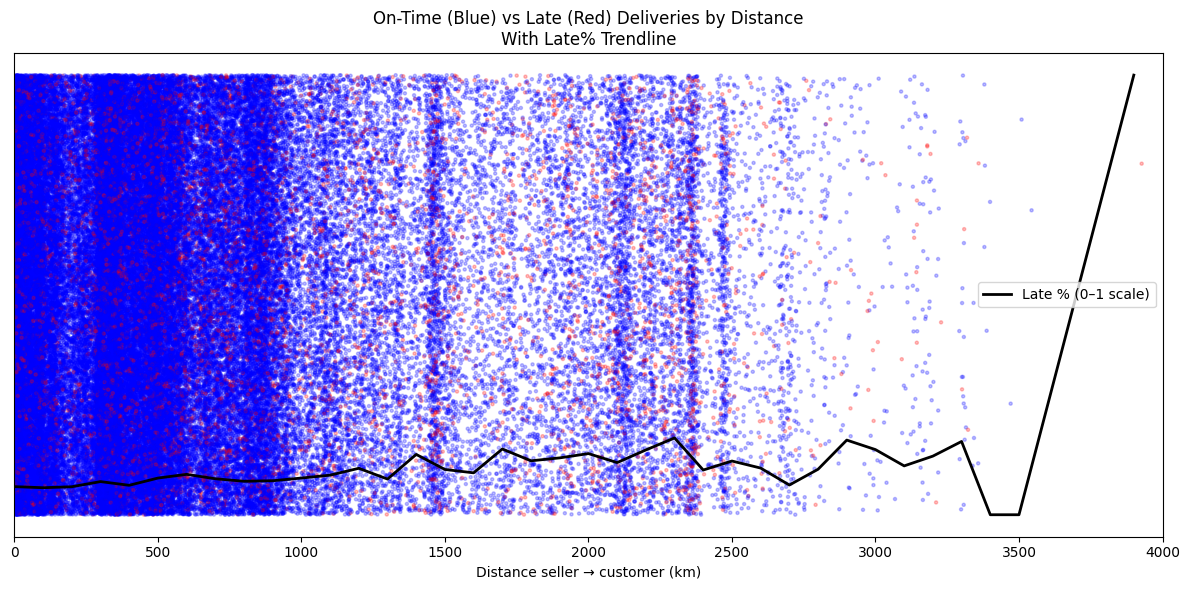

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 1. Load datasets
# ----------------------------
customers    = pd.read_csv("olist_customers_dataset.csv")
sellers      = pd.read_csv("olist_sellers_dataset.csv")
orders       = pd.read_csv("olist_orders_dataset.csv")
order_items  = pd.read_csv("olist_order_items_dataset.csv")
geo          = pd.read_csv("olist_geolocation_dataset.csv")

# ----------------------------
# 2. Prepare geolocation (zip → mean lat/lng)
# ----------------------------
geo_zip = (
    geo.groupby("geolocation_zip_code_prefix")
       .agg(
           geolocation_lat=("geolocation_lat", "mean"),
           geolocation_lng=("geolocation_lng", "mean")
       )
       .reset_index()
       .rename(columns={"geolocation_zip_code_prefix": "zip_prefix",
                        "geolocation_lat": "lat",
                        "geolocation_lng": "lng"})
)

# Customers with coords
customers_geo = (
    customers.rename(columns={"customer_zip_code_prefix": "zip_prefix"})
             .merge(geo_zip, on="zip_prefix", how="left")
             .rename(columns={"lat": "customer_lat", "lng": "customer_lng"})
)

# Sellers with coords
sellers_geo = (
    sellers.rename(columns={"seller_zip_code_prefix": "zip_prefix"})
           .merge(geo_zip, on="zip_prefix", how="left")
           .rename(columns={"lat": "seller_lat", "lng": "seller_lng"})
)

# ----------------------------
# 3. Merge orders, customers, sellers
# ----------------------------
orders_cust = (
    orders.merge(
        customers_geo[["customer_id", "customer_lat", "customer_lng"]],
        on="customer_id",
        how="left"
    )
)

order_items_sellers = (
    order_items.merge(
        sellers_geo[["seller_id", "seller_lat", "seller_lng"]],
        on="seller_id",
        how="left"
    )
)

merged = order_items_sellers.merge(
    orders_cust[
        [
            "order_id",
            "customer_lat",
            "customer_lng",
            "order_delivered_customer_date",
            "order_estimated_delivery_date"
        ]
    ],
    on="order_id",
    how="left"
)

# ----------------------------
# 4. Compute distance (Haversine)
# ----------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
    return R * c

merged["distance_km"] = haversine(
    merged["customer_lat"],
    merged["customer_lng"],
    merged["seller_lat"],
    merged["seller_lng"]
)

# ----------------------------
# 5. Flag late vs on-time
# ----------------------------
merged["order_delivered_customer_date"] = pd.to_datetime(
    merged["order_delivered_customer_date"], errors="coerce"
)
merged["order_estimated_delivery_date"] = pd.to_datetime(
    merged["order_estimated_delivery_date"], errors="coerce"
)

mask_dates = (
    merged["order_delivered_customer_date"].notna() &
    merged["order_estimated_delivery_date"].notna()
)

merged = merged[mask_dates].copy()
merged["late"] = (
    merged["order_delivered_customer_date"] >
    merged["order_estimated_delivery_date"]
)

# ----------------------------
# 6. Filter distances ≤ 4000 km
# ----------------------------
plotdf = merged[
    (merged["distance_km"].notna()) &
    (merged["distance_km"] <= 4000)
].copy()

# ----------------------------
# 7. Scatterplot with alpha + trendline
# ----------------------------
# Jitter y so points don't overlap
np.random.seed(42)
plotdf["y"] = np.random.uniform(0, 1, size=len(plotdf))

colors = np.where(plotdf["late"], "red", "blue")

plt.figure(figsize=(12, 6))

plt.scatter(
    plotdf["distance_km"],
    plotdf["y"],
    c=colors,
    s=5,
    alpha=0.25
)

# Trendline: late % by 100 km bins
bin_width = 100
plotdf["bin"] = (plotdf["distance_km"] // bin_width) * bin_width

trend = plotdf.groupby("bin")["late"].mean().sort_index()

plt.plot(
    trend.index,
    trend.values,
    color="black",
    linewidth=2,
    label="Late % (0–1 scale)"
)

plt.xlabel("Distance seller → customer (km)")
plt.yticks([])  # y is just jitter
plt.xlim(0, 4000)
plt.title("On-Time (Blue) vs Late (Red) Deliveries by Distance\nWith Late% Trendline")
plt.legend()
plt.tight_layout()
plt.show()


# Generate Map

In [ ]:
import folium
from folium.plugins import MarkerCluster

# ------------------------------------------
# Sample data (to avoid overloading the map)
# ------------------------------------------
sample = merged.dropna(subset=[
    "customer_lat", "customer_lng",
    "seller_lat", "seller_lng"
]).sample(1000)

# ------------------------------------------
# Center map on Brazil
# ------------------------------------------
m = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)

# Optional clustering for markers
marker_cluster = MarkerCluster().add_to(m)

# ------------------------------------------
# Plot lines + markers
# ------------------------------------------
for _, row in sample.iterrows():
    cust_coords = (row["customer_lat"], row["customer_lng"])
    sell_coords = (row["seller_lat"], row["seller_lng"])

    # Customer marker
    folium.CircleMarker(
        location=cust_coords,
        radius=2,
        color="blue",
        fill=True,
        fill_opacity=0.7,
        popup=f"Customer<br>Lat: {cust_coords[0]:.4f}<br>Lng: {cust_coords[1]:.4f}"
    ).add_to(marker_cluster)

    # Seller marker
    folium.CircleMarker(
        location=sell_coords,
        radius=2,
        color="green",
        fill=True,
        fill_opacity=0.7,
        popup=f"Seller<br>Lat: {sell_coords[0]:.4f}<br>Lng: {sell_coords[1]:.4f}"
    ).add_to(marker_cluster)

    # Line between them
    folium.PolyLine(
        locations=[cust_coords, sell_coords],
        color="red",
        weight=1,
        opacity=0.4
    ).add_to(m)

# ------------------------------------------
# Save map
# ------------------------------------------
m.save("customer_seller_map.html")
m


# Heatmap Sellers

In [ ]:
import folium
from folium.plugins import HeatMap

# -----------------------------------------------------------
# Filter dataset for valid seller coordinates
# -----------------------------------------------------------
valid = merged.dropna(subset=["seller_lat", "seller_lng"])

# -----------------------------------------------------------
# Build seller coordinate list
# -----------------------------------------------------------
seller_points = valid[["seller_lat", "seller_lng"]].values.tolist()

# -----------------------------------------------------------
# Create base map
# -----------------------------------------------------------
m = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)

# -----------------------------------------------------------
# Seller heatmap layer
# -----------------------------------------------------------
seller_heatmap = folium.FeatureGroup(name="Seller Heatmap")
seller_heatmap.add_child(
    HeatMap(seller_points, radius=8, blur=10, max_zoom=6)
)
m.add_child(seller_heatmap)

# -----------------------------------------------------------
# Seller point markers layer
# -----------------------------------------------------------
seller_points_layer = folium.FeatureGroup(name="Seller Points")

for lat, lng in seller_points:
    folium.CircleMarker(
        location=[lat, lng],
        radius=1,
        color="red",
        fill=True,
        fillOpacity=0.05
    ).add_to(seller_points_layer)

m.add_child(seller_points_layer)

# -----------------------------------------------------------
# Add layer toggle control
# -----------------------------------------------------------
folium.LayerControl().add_to(m)

# Save output
m.save("seller_heatmap_with_points.html")
